In [35]:
from pulp import *
import matplotlib.pyplot as plt
from functools import reduce

In [36]:
### macierz odleglosci
D = [
    [16.160, 24.080, 24.320, 21.120],
    [19.000, 26.470, 27.240, 17.330],
    [25.290, 32.490, 33.420, 12.250],
    [0.000, 7.930, 8.310, 36.120],
    [3.070, 6.440, 7.560, 37.360],
    [1.220, 7.510, 8.190, 36.290],
    [2.800, 10.310, 10.950, 33.500],
    [2.870, 5.070, 5.670, 38.800],
    [3.800, 8.010, 7.410, 38.160],
    [12.350, 4.520, 4.350, 48.270],
    [11.110, 3.480, 2.970, 47.140],
    [21.990, 22.020, 24.070, 39.860],
    [8.820, 3.300, 5.360, 43.310],
    [7.930, 0.000, 2.070, 43.750],
    [9.340, 2.250, 1.110, 45.430],
    [8.310, 2.070, 0.000, 44.430],
    [7.310, 2.440, 1.110, 43.430],
    [7.550, 0.750, 1.530, 43.520],
    [11.130, 18.410, 19.260, 25.400],
    [17.490, 23.440, 24.760, 23.210],
    [11.030, 18.930, 19.280, 25.430],
    [36.120, 43.750, 44.430, 0.000]
]

### pracochlonnosc
P = [0.1609, 0.1164, 0.1026, 0.1516, 0.0939, 0.1320, 0.0687, 0.0930, 0.2116, 0.2529, 0.0868, 0.0828, 0.0975, 0.8177,
     0.4115, 0.3795, 0.0710, 0.0427, 0.1043, 0.0997, 0.1698, 0.2531]

### OBECNY PRZYDZIAL
A = [
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 1],
]

### OBECNE LOKALIZACJE SIEDZIB
L = [4, 14, 16, 22]


In [37]:
def ecm(epsilon):
    problem = LpProblem(name=f"pfitzer(e={epsilon})", sense=LpMinimize)

    # utworzenie zmiennych decyzyjnych
    variables = []
    for region in range(len(A)):
        variables.append([])
        for agent in range(len(A[region])):
            variables[region].append(LpVariable(name=f"b_{region}_{agent}", cat='Binary'))


    # funkcja celu f1
    problem += lpSum([variables[r][a] * D[r][a] for a in range(len(variables[0])) for r in range(len(variables))]), "f1"

    # dodanie ograniczeń

    # jeden region - dokładnie jeden przedstawiciel
    for region in range(len(variables)):
        problem += lpSum([b for b in variables[region]]) == 1, f"one_agent_in_region_{region}"

    # suma pracochłonności
    for agent in range(len(variables[0])):
        problem += lpSum([variables[r][agent] * P[r] for r in range(len(variables))]) >= 0.9, f"min_labor_consumption_for_agent_{agent}"
        problem += lpSum([variables[r][agent] * P[r] for r in range(len(variables))]) <= 1.1, f"max_labor_consumption_for_agent_{agent}"

    # ograniczenie związane z kryterium f2
    problem += lpSum([variables[r][a] * P[r] * 0.25 for a in range(len(variables[0])) for r in range(len(variables)) if A[r][a] == 0]) <= epsilon, "f2_constraint"

    problem.solve()

    f1 = problem.objective.value()

    f2 = problem.constraints["f2_constraint"].value()- problem.constraints["f2_constraint"].constant
    
    return problem.status, f1, f2



In [38]:
f1_arr = []
f2_arr = []

points_limit = 10
no_points = 0

while no_points < points_limit:
    if no_points == 0:
        epsilon = 1
    else:
        epsilon = f2 - 0.0001
        
    status, f1, f2 = ecm(epsilon)
    if status == -1:
        break
    f1_arr.append(f1)
    f2_arr.append(f2)
    no_points += 1

print(len(f1_arr))
print(f2_arr)

10
[0.283525, 0.248625, 0.247475, 0.121675, 0.111, 0.0893, 0.08815, 0.084925, 0.083925, 0.063225]


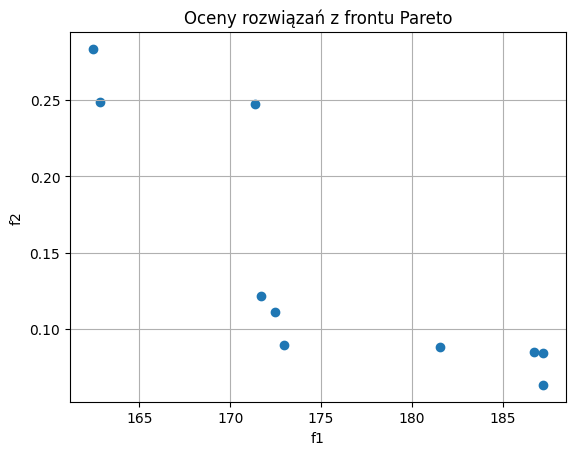

In [39]:
plt.scatter(f1_arr, f2_arr)
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("Oceny rozwiązań z frontu Pareto")
plt.grid()